In [98]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

train = pd.read_csv('train.csv', index_col=0)
test = pd.read_csv('test.csv', index_col=0)
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)
scaler = StandardScaler()
scaler1 =  MinMaxScaler()

column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))
train.drop("type",axis = 1,inplace=True)


train_yk = train[["type_num","fiberID"]]
train1 = train.drop(["type_num","fiberID"],axis=1)
feature_col = train1.columns
train_k = train1[train1[feature_col] < -2000]
train_k1 = train1[train1[feature_col] > 1000]
pre_index1 = set(train_k.dropna(how="all",axis=0).index)
pre_index2 = set(train_k1.dropna(how="all",axis=0).index)
pre_index = list(pre_index1|pre_index2)
train1 = train1.drop(pre_index,axis=0).reset_index(drop=True)
train_yk = train_yk.drop(pre_index,axis=0).reset_index(drop=True)
train = pd.concat([train_yk,train1[feature_col]],axis=1)
train = train.drop(train[(train["fiberMag_r"]<0)|(train["fiberMag_g"]<0)|(train["fiberMag_u"]<5)|(train["psfMag_r"]<0)|(train["psfMag_u"]>50)|(train["psfMag_z"]<5)|(train["psfMag_i"]>100)|
                        (train['petroMag_u']>100)|(train['petroMag_g']<-300)|(train['petroMag_z']<-100)|(train["psfMag_u"]<-20)|(train["fiberMag_u"]>100)
                        |(train['petroMag_i']<-20)|(train['modelMag_z']>40)|(train['modelMag_u']<10)|(train['petroMag_r']<-40)
                        |(train['petroMag_z']>150)|(train['petroMag_u']<-150)|(train['petroMag_r']>90)|(train['petroMag_i']>100)
                        |(train['petroMag_g']>200)|(train['modelMag_z']<10)|(train['modelMag_g']<10)].index).reset_index(drop=True)
test.loc[207051,'petroMag_g'] = -200
test.loc[207051,'psfMag_g'] = 100

In [108]:
train2 = train[["fiberID","type_num"]]
train2["count"] =1
train2_g = train2.groupby(["fiberID","type_num"]).count().unstack("type_num")
train2_g.fillna(0,inplace=True)
train_value = train["type_num"].value_counts().sort_index()
train2_g.columns = sample_submission.columns
for i, col in enumerate(train2_g.columns):
    train2_g[col] = train2_g[col]*100 / train_value[i]
train2_sc = scaler1.fit_transform(train2_g)
train2_sc = pd.DataFrame(train2_sc,columns = train2_g.columns, index = train2_g.index)
train2_sc.reset_index(inplace=True)

C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [110]:
# train_x = train.drop(['type_num','fiberID'], axis=1)
# train_y = train['type_num']
# test_x = test.drop('fiberID',axis=1)
train_x = train.drop('type_num', axis=1)
train_y = train['type_num']
test_x = test
sc_col = train_x.iloc[:,:21].columns
not_col = train_x.iloc[:,1:21].columns

In [111]:
set_d = pd.concat([train_x[sc_col],test_x[sc_col]],axis=0)
set_data = pd.DataFrame()
for i in sc_col:
    if i=='fiberID':
        set_data[i] = set_d[i]
    else:
        set_data[i] = set_d[i]-set_d[i].min()+100
        set_data[i] = np.log(set_data[i])
set_data = set_data.merge(train2_sc,on = 'fiberID',how='left')
set_data.drop('fiberID',axis=1,inplace=True)
test_box = set_data.iloc[199837:,:]
train_box = set_data.iloc[:199837,:]

In [115]:
train_box[not_col] = scaler.fit_transform(train_box[not_col])
test_box[not_col] = scaler.transform(test_box[not_col])

C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\pandas\core\frame.py:3493: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
C:\Users\Gyu\Anaconda3\envs\py37\lib\site-packages\pandas\core\frame.py:3464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://

In [119]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(test_size=0.15, random_state=42)

for train_index, test_index in split.split(train_box, train_y):
    x_train, y_train = train_box.loc[train_index], train_y[train_index]
    x_val, y_val = train_box.loc[test_index] , train_y[test_index]

In [142]:
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.layers import Activation
from keras import optimizers
from keras import regularizers
from keras import backend as K
from keras.utils import get_custom_objects

class mish(Activation):
    def __init__(self, activation, **kwargs):
        super(mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def Mish(x):
    return x*K.tanh(K.softplus(x))

get_custom_objects().update({'mish': mish(Mish)}) 

In [173]:

input_layer = Input(shape=(train_box.shape[1],))

## encoding part
encoded = Dense(100, activation='mish', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(75, activation='mish')(encoded)
encoded = Dense(50, activation='mish')(encoded)

## decoding part
decoded = Dense(50, activation='mish')(encoded)
decoded = Dense(75, activation='mish')(decoded)
decoded = Dense(100, activation='mish')(decoded)

## output layer
output_layer = Dense(train_box.shape[1], activation='linear')(decoded)
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adam", loss="mse")


In [179]:
autoencoder.fit(train_box,train_box , 
                batch_size = 512, epochs = 1, 
                shuffle = True, validation_split = 0.1)

Train on 179853 samples, validate on 19984 samples
Epoch 1/1
179853/179853 [==============================] - 2s 9us/step - loss: 0.0310 - val_loss: 0.0316


In [180]:
from keras.models import Sequential
hidden_representation = Sequential()
for i in range(len(autoencoder.layers)):
    hidden_representation.add(autoencoder.layers[i])

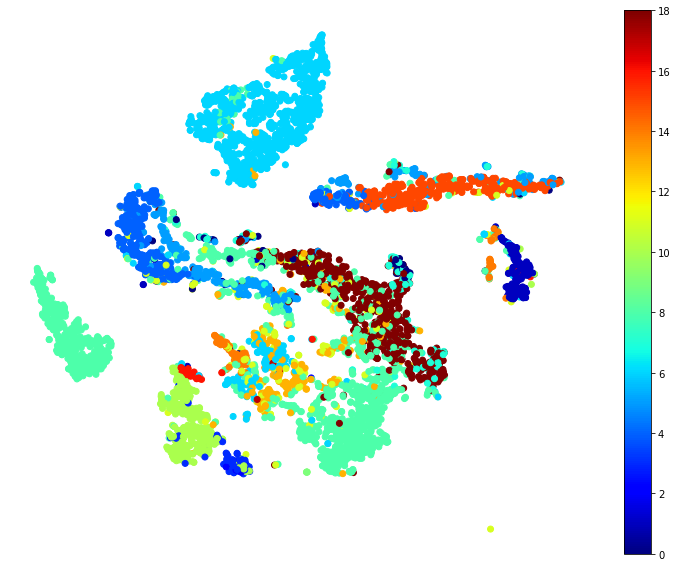

In [186]:
norm_hid_rep = hidden_representation.predict(train_box)
X_reduced = tsne.fit_transform(norm_hid_rep[:6000,:])
y = train_y[:6000]
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()


In [191]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(test_size=0.15, random_state=42)

for train_index, test_index in split.split(train_box, train_y):
    x_train, y_train = train_box.iloc[train_index,:], train_y[train_index]
    x_val, y_val = train_box.iloc[test_index,:] , train_y[test_index]

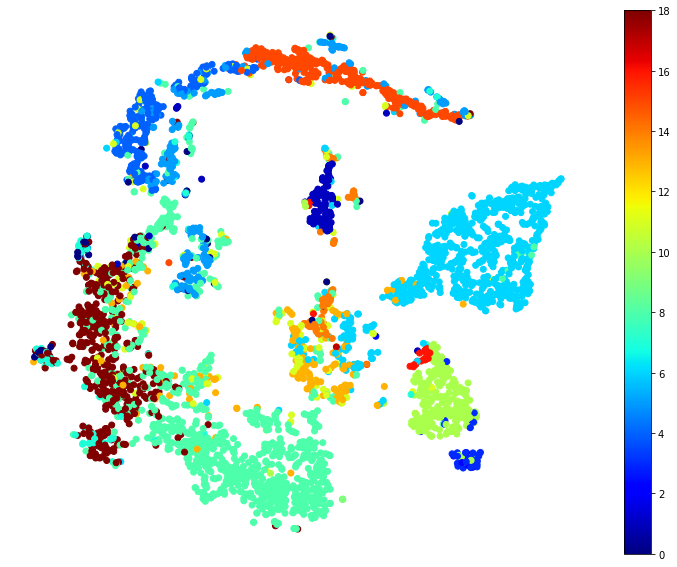

In [129]:
from sklearn.manifold import TSNE

X = train_box.iloc[:4000,:20]
y = train_y[:4000]
tsne = TSNE(learning_rate=300, n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()

In [195]:
y_train.value_counts()

8     42204
6     31699
18    18488
15    12435
4     12423
10    11683
5     11469
13     6060
11     5561
1      5529
7      3955
14     2767
3      2176
0      1835
16      981
2       425
9       108
17       52
12       11
Name: type_num, dtype: int64

In [196]:
# 언더 샘플링만 해보기~~
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
X_samp, y_samp = SMOTETomek(random_state=123, smote=SMOTE(sampling_strategy='auto', ratio={17:850}), 
                             tomek=TomekLinks(sampling_strategy='all',ratio = {8:42000,6:31000,18:17900})).fit_sample(x_train, y_train)

In [ ]:

pd.Series(y_samp).value_counts()

In [198]:
import lightgbm as lgb
lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=180, max_depth=-1, learning_rate=0.005, min_data_in_leaf = 4,
                             n_estimators=10000, subsample_for_bin=300000, objective='multiclass', min_split_gain=0.15, reg_alpha = 0.005, reg_lambda = 0.005,
                             min_child_weight=0.001, min_child_samples=17,n_jobs=-1, random_state=123,)
lgb_model = lgb_clf.fit(x_train, y_train, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=200)

Training until validation scores don't improve for 50 rounds
[200]	valid_0's multi_logloss: 0.89929
[400]	valid_0's multi_logloss: 0.57112
[600]	valid_0's multi_logloss: 0.449959
[800]	valid_0's multi_logloss: 0.400467
[1000]	valid_0's multi_logloss: 0.378934
[1200]	valid_0's multi_logloss: 0.368799
[1400]	valid_0's multi_logloss: 0.363796
[1600]	valid_0's multi_logloss: 0.361198
[1800]	valid_0's multi_logloss: 0.359913
[2000]	valid_0's multi_logloss: 0.359469
Early stopping, best iteration is:
[2069]	valid_0's multi_logloss: 0.359447


In [200]:
tmp = pd.DataFrame({'Feature': train_x.columns, 'Feature importance': lgb_model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (15,15))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

ValueError: arrays must all be same length

In [197]:
import lightgbm as lgb
lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=200, max_depth=-1, learning_rate=0.005, min_data_in_leaf = 4,
                             n_estimators=10000, subsample_for_bin=300000, objective='multiclass', min_split_gain=0.15, reg_alpha = 0.005, reg_lambda = 0.005,
                             min_child_weight=0.005, min_child_samples=17,n_jobs=-1, random_state=123,)
lgb_model = lgb_clf.fit(X_samp, y_samp, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=200)

Training until validation scores don't improve for 50 rounds
[200]	valid_0's multi_logloss: 0.896871
[400]	valid_0's multi_logloss: 0.569444
[600]	valid_0's multi_logloss: 0.450091
[800]	valid_0's multi_logloss: 0.40175
[1000]	valid_0's multi_logloss: 0.381508
[1200]	valid_0's multi_logloss: 0.372566
[1400]	valid_0's multi_logloss: 0.368125
[1600]	valid_0's multi_logloss: 0.366206
[1800]	valid_0's multi_logloss: 0.36566
Early stopping, best iteration is:
[1841]	valid_0's multi_logloss: 0.365647


In [191]:
import lightgbm as lgb
lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=300, max_depth=-1, learning_rate=0.003, min_data_in_leaf = 4,
                             n_estimators=5014, subsample_for_bin=300000, objective='multiclass', min_split_gain=0.3, reg_alpha = 0.005, reg_lambda = 0.005,
                             min_child_weight=0.004, min_child_samples=18,n_jobs=-1, random_state=123,)
lgb_model = lgb_clf.fit(X_samp, y_samp, eval_set = (x_val,y_val), early_stopping_rounds=50, verbose=200)

Training until validation scores don't improve for 50 rounds
[200]	valid_0's multi_logloss: 1.17835
[400]	valid_0's multi_logloss: 0.799408
[600]	valid_0's multi_logloss: 0.609882
[800]	valid_0's multi_logloss: 0.507216
[1000]	valid_0's multi_logloss: 0.450144
[1200]	valid_0's multi_logloss: 0.417596
[1400]	valid_0's multi_logloss: 0.398672
[1600]	valid_0's multi_logloss: 0.38734
[1800]	valid_0's multi_logloss: 0.380187
[2000]	valid_0's multi_logloss: 0.375701
[2200]	valid_0's multi_logloss: 0.372987
[2400]	valid_0's multi_logloss: 0.371159
[2600]	valid_0's multi_logloss: 0.370027
[2800]	valid_0's multi_logloss: 0.369355
[3000]	valid_0's multi_logloss: 0.368787
[3200]	valid_0's multi_logloss: 0.368404
[3400]	valid_0's multi_logloss: 0.368093
[3600]	valid_0's multi_logloss: 0.367806
[3800]	valid_0's multi_logloss: 0.367676
[4000]	valid_0's multi_logloss: 0.36756
[4200]	valid_0's multi_logloss: 0.367489
[4400]	valid_0's multi_logloss: 0.367445
[4600]	valid_0's multi_logloss: 0.367423
[48

(19.0, 0.0)

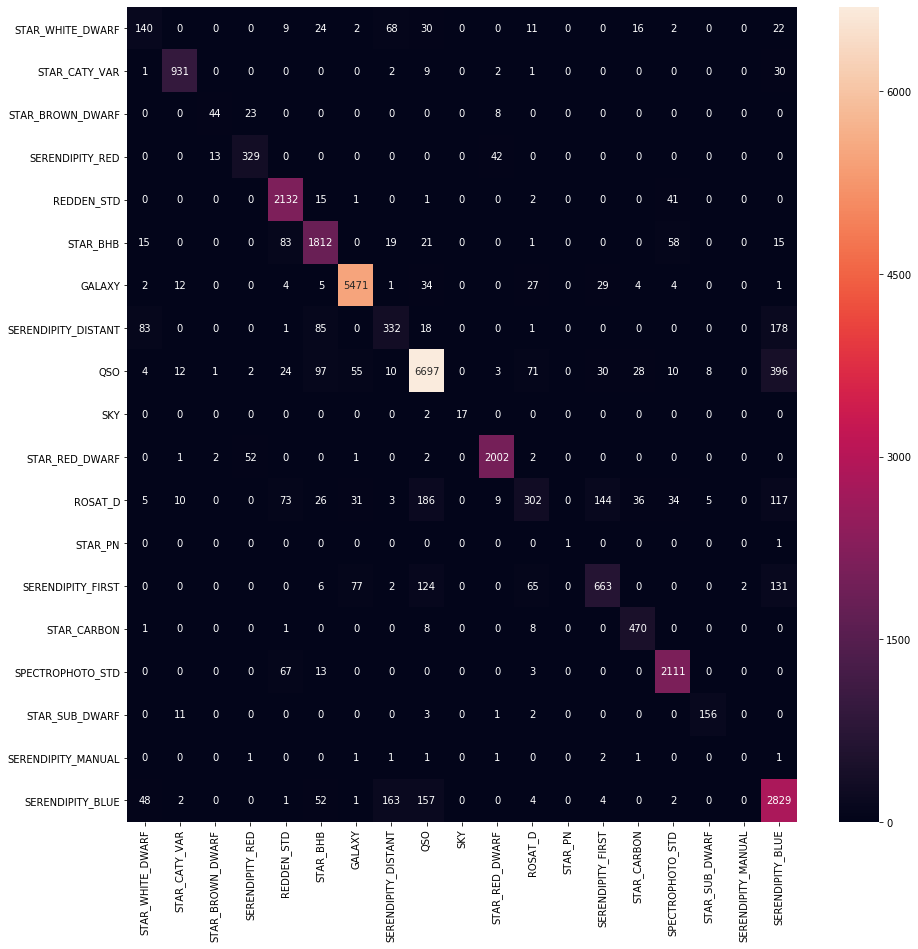

In [121]:
from sklearn.metrics import confusion_matrix
y_pred = lgb_model.predict(x_val)
plt.figure(figsize=(15,15))
ax = sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d" 
                  ,yticklabels=sample_submission.columns, xticklabels=sample_submission.columns
                )
buttom, top = ax.get_ylim()
ax.set_ylim(buttom+0.5,top-0.5)

(19.0, 0.0)

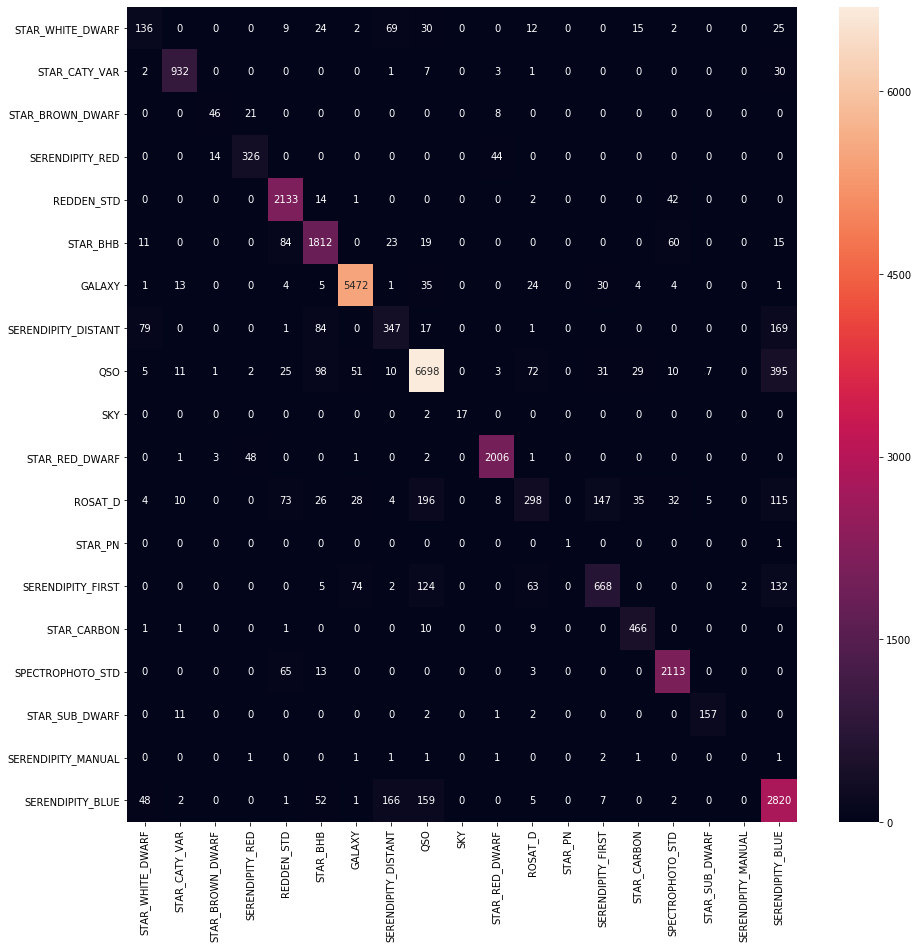

In [193]:
from sklearn.metrics import confusion_matrix
y_pred = lgb_model.predict(x_val)
plt.figure(figsize=(15,15))
ax = sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d" 
                  ,yticklabels=sample_submission.columns, xticklabels=sample_submission.columns
                )
buttom, top = ax.get_ylim()
ax.set_ylim(buttom+0.5,top-0.5)

In [122]:
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.47      0.43      0.45       324
           1       0.95      0.95      0.95       976
           2       0.73      0.59      0.65        75
           3       0.81      0.86      0.83       384
           4       0.89      0.97      0.93      2192
           5       0.85      0.90      0.87      2024
           6       0.97      0.98      0.97      5594
           7       0.55      0.48      0.51       698
           8       0.92      0.90      0.91      7448
           9       1.00      0.89      0.94        19
          10       0.97      0.97      0.97      2062
          11       0.60      0.31      0.41       981
          12       1.00      0.50      0.67         2
          13       0.76      0.62      0.68      1070
          14       0.85      0.96      0.90       488
          15       0.93      0.96      0.95      2194
          16       0.92      0.90      0.91       173
          17       0.00    

In [194]:
from sklearn.metrics import classification_report
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.47      0.42      0.45       324
           1       0.95      0.95      0.95       976
           2       0.72      0.61      0.66        75
           3       0.82      0.85      0.83       384
           4       0.89      0.97      0.93      2192
           5       0.85      0.90      0.87      2024
           6       0.97      0.98      0.97      5594
           7       0.56      0.50      0.52       698
           8       0.92      0.90      0.91      7448
           9       1.00      0.89      0.94        19
          10       0.97      0.97      0.97      2062
          11       0.60      0.30      0.40       981
          12       1.00      0.50      0.67         2
          13       0.75      0.62      0.68      1070
          14       0.85      0.95      0.90       488
          15       0.93      0.96      0.95      2194
          16       0.93      0.91      0.92       173
          17       0.00    

In [199]:
y_test = lgb_model.predict_proba(test_box)
submission = pd.DataFrame(data=y_test, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('submission1.csv', index=True)

In [140]:
y_get = lgb_model.predict(x_train)


In [154]:
not_yet = pd.DataFrame([y_get,y_train],index=["pred","train"]).T
not_yet=not_yet[not_yet["pred"]!=not_yet['train']]
not_index = not_yet.index
x_not = x_train[not_index,:]

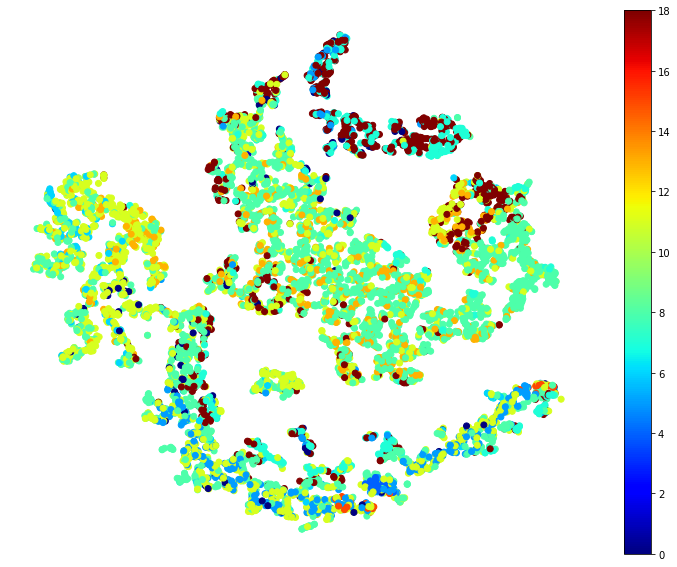

In [158]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
X = PCA(n_components=0.9,).fit_transform(x_not)
y = not_yet['train']
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()

,pred,train
9,18,8
26,18,8
49,18,11
75,18,8
90,18,7
99,18,8
121,5,18
155,5,7
170,18,11
197,1,11
